### Value iteration

Implement value iteration and use it to estimate 𝜋∗
for the grid world
in Exercise gw/simple.

In [2]:
import numpy as np
from matplotlib import pyplot as plt

In [3]:
def softmax(x, axis=0):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=axis)

In [49]:
class Enviroment:
    
    def __init__(self, w, h):
        self.w = w
        self.h = h
        
        self.R = -np.ones((w, h))
        self.actions = ["up", "down", "left", "right"]
        
        self.states = [(x, y) for x in range(self.w) for y in range(self.h)]
        self.terminal = [(0,0), (w-1, h-1)]
                    
    def sprime(self, s:np.array, a:int) -> tuple:
        # actions: (0,1,2,3) = (up, down, left, right)
        actions = {
            0: np.array((-1, 0)),
            1: np.array((1, 0)),
            2: np.array((0, -1)),
            3: np.array((0, 1))
        }
        s_prime = s + actions[a]
        s_prime[0] = max(min(s_prime[0], self.w-1), 0)
        s_prime[1] = max(min(s_prime[1], self.h-1), 0)
        
        return tuple(s_prime)

    def reward(self, s:np.array, a: int) -> float:
        s_prime = self.sprime(s, a)
        reward = self.R[s_prime[0], s_prime[1]]

        return reward

    def cumulative_reward(self, s, π, γ=0.9, max_steps=1):
        if s in self.terminal:
            return 0
        reward = 0
        
        for a in range(π.shape[0]):
            sprime = self.sprime(s, a)
            
            if max_steps > 1:
                reward += π[a, s[0], s[1]]*(self.reward(s, a) + γ*self.cumulative_reward(sprime, π, γ, max_steps-1))
            else:
                reward += π[a, s[0], s[1]]*self.reward(s, a)
        return reward

class Agent:
    
    def __init__(self, w, h):
        self.w = w
        self.h = h
        self.actions = ["up", "down", "left", "right"]
        
        self.terminal = [(0,0), (w-1, h-1)]
        
        self._π = softmax(np.ones((4, w, h))); # equiprob policy
        self._V = np.random.rand(self.w, self.h)      
        for t in self.terminal:
            self._V[t] = 0
    
    def π(self, a, s):
        return self._π[a, s[0], s[1]]
    
    def V(self, s):
        return self._V[s]
        
    def iterative_policy_evaluation(self, env, γ=1.0, θ=0.1, max_steps=1000):

        Δ = θ+1
        steps = 0
        while Δ > θ:
            Δ = 0
            for s in env.states:
                if s in self.terminal:
                    continue

                v = self.V(s)
                v_new = 0

                # The additional sum over s', r can be ignored in our case because our enviroment is deterministic
                # i.e. for a given state s and action a the outcome is s'(a) and r(s')
                for a in range(len(self.actions)):
                    sprime = env.sprime(s, a)
                    v_new += self.π(a, s)*(env.reward(s, a) + γ*self.V(sprime))

                self._V[s] = v_new
                Δ = max(Δ, abs(v - self.V(s)))
                    
            steps += 1
            if steps > max_steps:
                print(f'Reached max step. {Δ=}.')
                return self._V
            
        print(f'{steps=}')
        return self._V
    
    def policy_iteration(self, env, γ=1.0, θ=0.1, max_steps=1000):
        policy_stable = True
        
        steps = 0
        while policy_stable:
            steps += 1
            for s in env.states:
                π_old = self._π[:, s[0], s[1]]
                π_new = np.zeros(len(self.actions))

                optimal_reward = -np.inf
                for a in range(len(self.actions)):
                    sprime = env.sprime(s, a)
                    a_exp_reward = (env.reward(s, a) + γ*self.V(sprime))

                    if a_exp_reward > optimal_reward:
                        optimal_reward = a_exp_reward
                        π_new = np.zeros(len(self.actions))
                        π_new[a] = 1

                if (π_new != π_old).any():
                    policy_stable = False
                self._π[:, s[0], s[1]] = π_new

            if policy_stable:
                print(f'policy iteration steps = {steps}')
                return self._V, self._π
            else:
                self.iterative_policy_evaluation(env=env, γ=γ, θ=θ, max_steps=max_steps)
                policy_stable = True
                
    def value_iteration(self, env, γ=1.0, θ=0.1, max_steps=1000):

        Δ = θ+1
        steps = 0
        while Δ > θ:
            Δ = 0
            for s in env.states:
                if s in self.terminal:
                    continue

                v = self.V(s)
                v_new = -np.inf                
                
                # The additional sum over s', r can be ignored in our case because our enviroment is deterministic
                # i.e. for a given state s and action a the outcome is s'(a) and r(s')
                for a in range(len(self.actions)):
                    sprime = env.sprime(s, a)
                    v_new = max(v_new, (env.reward(s, a) + γ*self.V(sprime)))

                self._V[s] = v_new
                Δ = max(Δ, abs(v - self.V(s)))
                    
            steps += 1
            if steps > max_steps:
                print(f'Reached max step. {Δ=}.')
                return self._V
                        
        # Compute optimal policy
        for s in env.states:
            π_new = np.zeros(len(self.actions))

            optimal_reward = -np.inf
            for a in range(len(self.actions)):
                sprime = env.sprime(s, a)
                a_exp_reward = (env.reward(s, a) + γ*self.V(sprime))

                if a_exp_reward > optimal_reward:
                    optimal_reward = a_exp_reward
                    π_new = np.zeros(len(self.actions))
                    π_new[a] = 1

            self._π[:, s[0], s[1]] = π_new
                                    
        print(f'{steps=}')
        return self._V, self._π
        
        
        

In [50]:
w, h = 4, 4

grid = Enviroment(w, h)
agent = Agent(w, h)

V_out, π_out = agent.value_iteration(grid, γ=1.0, θ=0.01, max_steps=100)

print(V_out)

steps=5
[[ 0. -1. -2. -3.]
 [-1. -2. -3. -2.]
 [-2. -3. -2. -1.]
 [-3. -2. -1.  0.]]


steps=21


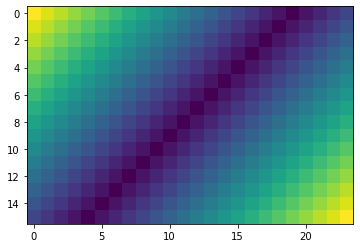

In [51]:
w, h = 16, 24

grid = Enviroment(w, h)
agent = Agent(w, h)

V_out, π_out = agent.value_iteration(grid, γ=1.0, θ=0.01, max_steps=100)

plt.imshow(V_out)

up


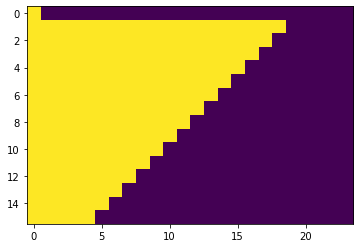

In [45]:
a = 0
print(agent.actions[a])
plt.imshow(π_out[a])

down


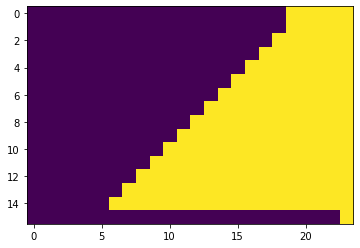

In [46]:
a = 1
print(agent.actions[a])
plt.imshow(π_out[a])

left


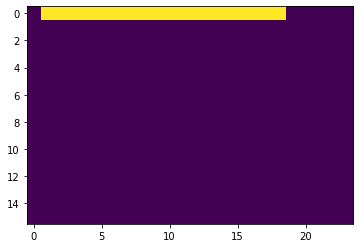

In [47]:
a = 2
print(agent.actions[a])
plt.imshow(π_out[a])

right


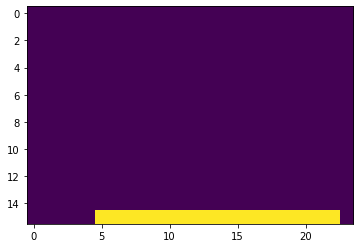

In [48]:
a = 3
print(agent.actions[a])
plt.imshow(π_out[a])